In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.layers import Input
from tcn import TCN

In [2]:
df = pd.read_csv(r'C:\Users\jocke\Desktop\Skola\Agilt\optiver-trading-at-the-close\train.csv')

In [3]:
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [4]:
df['far_price'].fillna(df['far_price'].mean(), inplace=True)
df['near_price'].fillna(df['near_price'].mean(), inplace=True)
df['reference_price'].fillna(df['reference_price'].mean(), inplace=True)
df['imbalance_size'].fillna(df['imbalance_size'].mean(), inplace=True)
df['matched_size'].fillna(df['matched_size'].mean(), inplace=True)
df['wap'].fillna(df['wap'].mean(), inplace=True)
df['target'].fillna(df['target'].mean(), inplace=True)
df['bid_price'].fillna(df['bid_price'].mean(), inplace=True)
df['ask_price'].fillna(df['ask_price'].mean(), inplace=True)

In [5]:
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.001713,0.999660,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,1.001713,0.999660,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,1.001713,0.999660,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,1.001713,0.999660,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,1.001713,0.999660,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [6]:
df.shape

(5237980, 17)

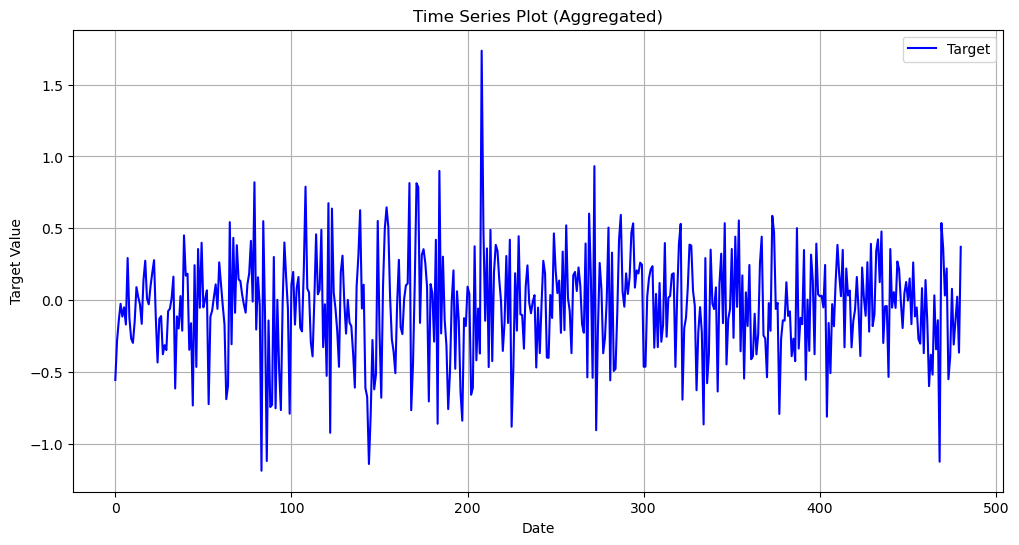

In [7]:
grouped = df.groupby('date_id')['target'].mean().reset_index()

plt.figure(figsize=(12, 6))

plt.plot(grouped['date_id'], grouped['target'], label='Target', color='blue')

plt.xlabel('Date')
plt.ylabel('Target Value')
plt.title('Time Series Plot (Aggregated)')

plt.legend()

plt.grid(True)
plt.show()

In [8]:
X = df['date_id'].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

time_steps = 10

#Skapar sekvens för train och test
X_train_sequences = []
y_train_sequences = []
for i in range(len(X_train) - time_steps):
    X_train_sequences.append(X_train[i:i+time_steps])
    y_train_sequences.append(y_train[i+time_steps])

X_test_sequences = []
y_test_sequences = []

for i in range(len(X_test) - time_steps):
    X_test_sequences.append(X_test[i:i+time_steps])
    y_test_sequences.append(y_test[i+time_steps])

X_test_sequences = []
y_test_sequences = []

for i in range(len(X_test) - time_steps):
    X_test_sequences.append(X_test[i:i+time_steps])
    y_test_sequences.append(y_test[i+time_steps])
#To numpy
X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)
X_test_sequences = np.array(X_test_sequences)
y_test_sequences = np.array(y_test_sequences)

In [9]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1), return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(X_train_sequences, y_train_sequences, epochs=5, batch_size=32)

loss = model.evaluate(X_test_sequences, y_test_sequences)
print(f'Test loss: {loss}')

Epoch 1/5
130950/130950 [==============================] - 452s 3ms/step - loss: 6.4955
Epoch 2/5
130950/130950 [==============================] - 448s 3ms/step - loss: 6.4955
Epoch 3/5
130950/130950 [==============================] - 447s 3ms/step - loss: 6.4955
Epoch 4/5
130950/130950 [==============================] - 430s 3ms/step - loss: 6.4955
Epoch 5/5
32738/32738 [==============================] - 57s 2ms/step - loss: 6.0556
Test loss: 6.055621147155762


# 12% sämre än bästa modell.